In [2]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [3]:
# from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

tf.keras.backend.set_floatx('float32')

ModuleNotFoundError: No module named 'numpy'

In [ ]:
# get all data
df = pd.read_csv("/content/drive/MyDrive/bitcoin_ticker.csv")

# Scale the labels
scale_factor = 1000.0
# Scale the main set's label.
df[["last","bid","ask","low","diff_24h","high","volume"]] /= scale_factor 

# get btc data
df = df.loc[(df['rpt_key'] == 'btc_usd')]

In [ ]:
# buils train data frame and test data frame
train_last_index = int(len(df) * 0.80)
train_df, test_df = df.iloc[0:train_last_index], df.iloc[train_last_index:len(df)]
# Shuffle the examples
train_df = train_df.reindex(np.random.permutation(train_df.index))

this part is just a normal and one dimentional regrassion


In [ ]:
feature_columns = []

bid = tf.feature_column.numeric_column('bid')
feature_columns.append(bid)

ask = tf.feature_column.numeric_column('ask')
feature_columns.append(ask)

low = tf.feature_column.numeric_column('low')
feature_columns.append(low)

diff_24h = tf.feature_column.numeric_column('diff_24h')
feature_columns.append(diff_24h)

high = tf.feature_column.numeric_column('high')
feature_columns.append(high)

volume = tf.feature_column.numeric_column('volume')
feature_columns.append(volume)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
fp_feature_layer = layers.DenseFeatures(feature_columns)

In [ ]:
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model           


def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # Isolate the mean absolute error for each epoch.
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse   


def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.94, rmse.max()* 1.05])
  plt.show()  

print("Defined the create_model, train_model, and plot_the_loss_curve functions.")

Defined the create_model, train_model, and plot_the_loss_curve functions.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/30
1004/1004 [==============================] - 6s 5ms/step - loss: 0.4021 - root_mean_squared_error: 0.6341
Epoch 2/30
1004/1004 [==============================] - 5s 5ms/step - loss: 0.3430 - root_mean_squared_error: 0.5857
Epoch 3/30
1004/1004 [==============================] - 5s 5ms/step - loss: 0.3405 - root_mean_squared_error: 0.5835
Epoch 4/30
1004/1004 [==============================] - 5s 5ms/step - loss: 0.3418 - root_mean_squared_error: 0.5846
Epoch 5/30
1004/1004 [==============================] - 5s 5ms/step - loss: 0.3405 - root_mean_squared_error: 0.5835
Epoch 6/30
1004/1004 [==============================] - 5s 5ms/step - loss: 0.3400 - root_mean_squared_error: 0.5831
Epoch 7/30
1004/1004 [==============================] - 5s 5ms/step - loss: 0.3390 - root_mean_squared_error: 0.5822
Epoch 8/30
1004/1004 [==============================] - 5s 5ms/step - loss: 0.3391 - root_mean_squared_error: 0.5823
Epoch 9/30
1004/1004 [==============================] - 5s 5ms/s

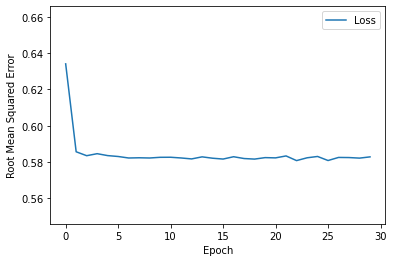


: Evaluate the new model against the test set:
251/251 [==============================] - 1s 2ms/step - loss: 0.2175 - root_mean_squared_error: 0.4664


[0.2175428569316864, 0.4664148986339569]

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.05
epochs = 30
batch_size = 100
label_name = 'last'

# Create and compile the model's topography.
my_model = create_model(learning_rate, fp_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

in this part we represent our features in buckets (bins)

In [ ]:
train_df.count()

date_id        100350
datetime_id    100350
market         100350
rpt_key        100350
last           100350
                ...  
low            100350
high           100350
volume         100350
created_at     100350
updated_at     100350
Length: 14, dtype: int64

In [ ]:
resolution_in_degrees = 10

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

# Create a bucket feature column for bid.
bid_as_a_numeric_column = tf.feature_column.numeric_column("bid")
bid_boundaries = list(np.arange(int(min(train_df['bid'])), 
                                     int(max(train_df['bid'])), 
                                     resolution_in_degrees))
bid = tf.feature_column.bucketized_column(bid_as_a_numeric_column, 
                                               bid_boundaries)
feature_columns.append(bid)


# Create a bucket feature column for ask.
ask_as_a_numeric_column = tf.feature_column.numeric_column("ask")
ask_boundaries = list(np.arange(int(min(train_df['ask'])), 
                                     int(max(train_df['ask'])), 
                                     resolution_in_degrees))
ask = tf.feature_column.bucketized_column(ask_as_a_numeric_column, 
                                               ask_boundaries)
feature_columns.append(ask)


# Create a bucket feature column for diff_24h.
diff_24h_as_a_numeric_column = tf.feature_column.numeric_column("diff_24h")
diff_24h_boundaries = list(np.arange(int(min(train_df['diff_24h'])), 
                                     int(max(train_df['diff_24h'])), 
                                     resolution_in_degrees))
diff_24h = tf.feature_column.bucketized_column(diff_24h_as_a_numeric_column, 
                                              diff_24h_boundaries)
feature_columns.append(diff_24h)


# Create a bucket feature column for high.
high_as_a_numeric_column = tf.feature_column.numeric_column("high")
high_boundaries = list(np.arange(int(min(train_df['high'])), 
                                     int(max(train_df['high'])), 
                                     resolution_in_degrees))
high = tf.feature_column.bucketized_column(high_as_a_numeric_column, 
                                              high_boundaries)
feature_columns.append(high)

# Create a bucket feature column for volume.
volume_as_a_numeric_column = tf.feature_column.numeric_column("volume")
volume_boundaries = list(np.arange(int(min(train_df['volume'])), 
                                     int(max(train_df['volume'])), 
                                     resolution_in_degrees))
volume = tf.feature_column.bucketized_column(volume_as_a_numeric_column, 
                                              volume_boundaries)
feature_columns.append(volume)

# # Create a bucket feature column for diff_per_24h.
# diff_per_24h_as_a_numeric_column = tf.feature_column.numeric_column("diff_per_24h")
# diff_per_24h_boundaries = list(np.arange(int(min(train_df['diff_per_24h'])), 
#                                      int(max(train_df['diff_per_24h'])), 
#                                      resolution_in_degrees))
# diff_per_24h = tf.feature_column.bucketized_column(diff_per_24h_as_a_numeric_column, 
#                                               diff_per_24h_boundaries)
# feature_columns.append(diff_per_24h)


# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
buckets_feature_layer = layers.DenseFeatures(feature_columns) 

Epoch 1/35


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


1004/1004 [==============================] - 7s 6ms/step - loss: 0.0376 - root_mean_squared_error: 0.1939
Epoch 2/35
1004/1004 [==============================] - 6s 6ms/step - loss: 0.0336 - root_mean_squared_error: 0.1833
Epoch 3/35
1004/1004 [==============================] - 7s 7ms/step - loss: 0.0335 - root_mean_squared_error: 0.1831
Epoch 4/35
1004/1004 [==============================] - 6s 6ms/step - loss: 0.0337 - root_mean_squared_error: 0.1836
Epoch 5/35
1004/1004 [==============================] - 6s 6ms/step - loss: 0.0337 - root_mean_squared_error: 0.1836
Epoch 6/35
1004/1004 [==============================] - 6s 6ms/step - loss: 0.0336 - root_mean_squared_error: 0.1834
Epoch 7/35
1004/1004 [==============================] - 5s 5ms/step - loss: 0.0337 - root_mean_squared_error: 0.1835
Epoch 8/35
1004/1004 [==============================] - 6s 6ms/step - loss: 0.0339 - root_mean_squared_error: 0.1840
Epoch 9/35
1004/1004 [==============================] - 6s 6ms/step - loss:

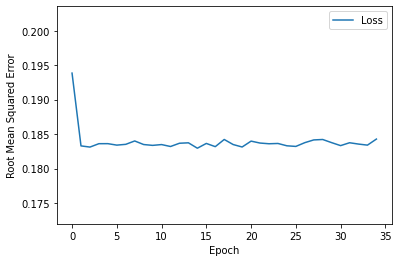


: Evaluate the new model against the test set:


251/251 [==============================] - 1s 2ms/step - loss: 0.0964 - root_mean_squared_error: 0.3105


[0.09641648083925247, 0.3105100393295288]

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the buckets_feature_layer.
my_model = create_model(learning_rate, buckets_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

>> now time for feature cross

In [ ]:
resolution_in_degrees = 0.1

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

# Create a bucket feature column for bid.
bid_as_a_numeric_column = tf.feature_column.numeric_column("bid")
bid_boundaries = list(np.arange(int(min(train_df['bid'])), 
                                     int(max(train_df['bid'])), 
                                     resolution_in_degrees))
bid = tf.feature_column.bucketized_column(bid_as_a_numeric_column, 
                                               bid_boundaries)
feature_columns.append(bid)


# Create a bucket feature column for ask.
ask_as_a_numeric_column = tf.feature_column.numeric_column("ask")
ask_boundaries = list(np.arange(int(min(train_df['ask'])), 
                                     int(max(train_df['ask'])), 
                                     resolution_in_degrees))
ask = tf.feature_column.bucketized_column(ask_as_a_numeric_column, 
                                               ask_boundaries)
feature_columns.append(ask)


# Create a bucket feature column for diff_24h.
diff_24h_as_a_numeric_column = tf.feature_column.numeric_column("diff_24h")
diff_24h_boundaries = list(np.arange(int(min(train_df['diff_24h'])), 
                                     int(max(train_df['diff_24h'])), 
                                     resolution_in_degrees))
diff_24h = tf.feature_column.bucketized_column(diff_24h_as_a_numeric_column, 
                                              diff_24h_boundaries)
feature_columns.append(diff_24h)


# Create a bucket feature column for high.
high_as_a_numeric_column = tf.feature_column.numeric_column("high")
high_boundaries = list(np.arange(int(min(train_df['high'])), 
                                     int(max(train_df['high'])), 
                                     resolution_in_degrees))
high = tf.feature_column.bucketized_column(high_as_a_numeric_column, 
                                              high_boundaries)
feature_columns.append(high)

# Create a bucket feature column for volume.
volume_as_a_numeric_column = tf.feature_column.numeric_column("volume")
volume_boundaries = list(np.arange(int(min(train_df['volume'])), 
                                     int(max(train_df['volume'])), 
                                     resolution_in_degrees))
volume = tf.feature_column.bucketized_column(volume_as_a_numeric_column, 
                                              volume_boundaries)
feature_columns.append(volume)

# Create a feature cross of all fitures
bid_x_ask_x_high_x_diff_24h_x_volume = tf.feature_column.crossed_column([bid, ask, high, diff_24h, volume], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(bid_x_ask_x_high_x_diff_24h_x_volume)
feature_columns.append(crossed_feature)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_cross_feature_layer = layers.DenseFeatures(feature_columns)

Epoch 1/35


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


1004/1004 [==============================] - 7s 6ms/step - loss: 0.0355 - root_mean_squared_error: 0.1885
Epoch 2/35
1004/1004 [==============================] - 6s 6ms/step - loss: 0.0205 - root_mean_squared_error: 0.1431
Epoch 3/35
1004/1004 [==============================] - 6s 6ms/step - loss: 0.0206 - root_mean_squared_error: 0.1434
Epoch 4/35
1004/1004 [==============================] - 6s 6ms/step - loss: 0.0206 - root_mean_squared_error: 0.1434
Epoch 5/35
1004/1004 [==============================] - 6s 6ms/step - loss: 0.0205 - root_mean_squared_error: 0.1432
Epoch 6/35
1004/1004 [==============================] - 6s 5ms/step - loss: 0.0205 - root_mean_squared_error: 0.1432
Epoch 7/35
1004/1004 [==============================] - 6s 6ms/step - loss: 0.0206 - root_mean_squared_error: 0.1434
Epoch 8/35
1004/1004 [==============================] - 6s 5ms/step - loss: 0.0205 - root_mean_squared_error: 0.1433
Epoch 9/35
1004/1004 [==============================] - 6s 6ms/step - loss:

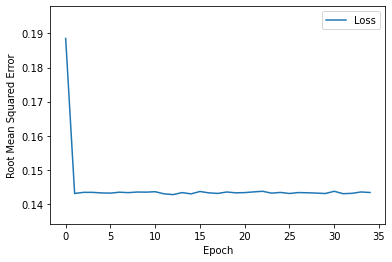


: Evaluate the new model against the test set:


251/251 [==============================] - 1s 3ms/step - loss: 0.0438 - root_mean_squared_error: 0.2094


[0.04384041205048561, 0.20938101410865784]

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the feature_cross_feature_layer: 
my_model = create_model(learning_rate, feature_cross_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)